In [1]:
%%capture
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from tabulate import tabulate

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
EXTRACTED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/extracted_features_iemocap.csv"
SCALED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/scaled_features_iemocap.csv"
CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/config.json"
RAW_AUDIO_FILES = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/raw_audio_files.csv"
AUDIO_SPECTOGRAMS_DIR = './../data/spectograms/'

config = Configuration.load_json(CONFIG_FILE)

OneHotEncodingConfig = {'0': [1, 0], '1': [0, 1]}
plt.rcParams['figure.dpi'] = 300

In [2]:
def get_metrics(y_labels, y_pred, folds_size):
    accs = []
    i = 0
    for f_i in range(5):
        acc = round(metrics.accuracy_score(
            y_labels[i:i+folds_size[f_i]], y_pred[i:i+folds_size[f_i]]) * 100, 2)
        print(f"Accuracy for fold {f_i}: {acc}%")
        i += folds_size[f_i]
        accs.append(acc)
    
    mean_acc = f"{round(metrics.accuracy_score(y_labels, y_pred) * 100, 2)}+-{round(np.std(accs), 2)}"

    table = [
        ["Accuracy", mean_acc],
        ["F1 score macro", round(metrics.f1_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Precision", round(metrics.precision_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Recall", round(metrics.recall_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Matthews corrcoef", round(
            metrics.matthews_corrcoef(y_labels, y_pred), 3)],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))

    ticks = ['0 - negative', '1 - positive']
    cm = metrics.confusion_matrix(y_labels, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=ticks, yticklabels=ticks)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Emotion Label")
    plt.ylabel("Real Emotion Label")
    plt.yticks(rotation=0)
    plt.show()

    return mean_acc

def categorical_cross_validation(get_new_model, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
    
    X = df.iloc[:,8:]
    y = df.iloc[:,4:5]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
        folds_size.append(len(y_test))
        
        model.fit(X_train, y_train.values.ravel())

        y_pred = model.predict(X_test)
        all_y_pred.extend(y_pred)
        y_test = np.reshape(y_test.values, y_pred.shape)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    results.append([used_labels, get_metrics(all_y_labels, all_y_pred, folds_size)])

    return results

results = []

Angry, Sad, Neutral, Happy+Excited

Number of Audio Files: 5531
                   Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
excited 1             1041
happy   1              595
neutral 3             1708
sad     2             1084
Accuracy for fold 0: 59.8%
Accuracy for fold 1: 60.67%
Accuracy for fold 2: 60.04%
Accuracy for fold 3: 60.94%
Accuracy for fold 4: 59.86%

Metric             Value
-----------------  -----------
Accuracy           60.26+-0.46
F1 score macro     60.93
Precision          61.93
Recall             60.49
Matthews corrcoef  0.462


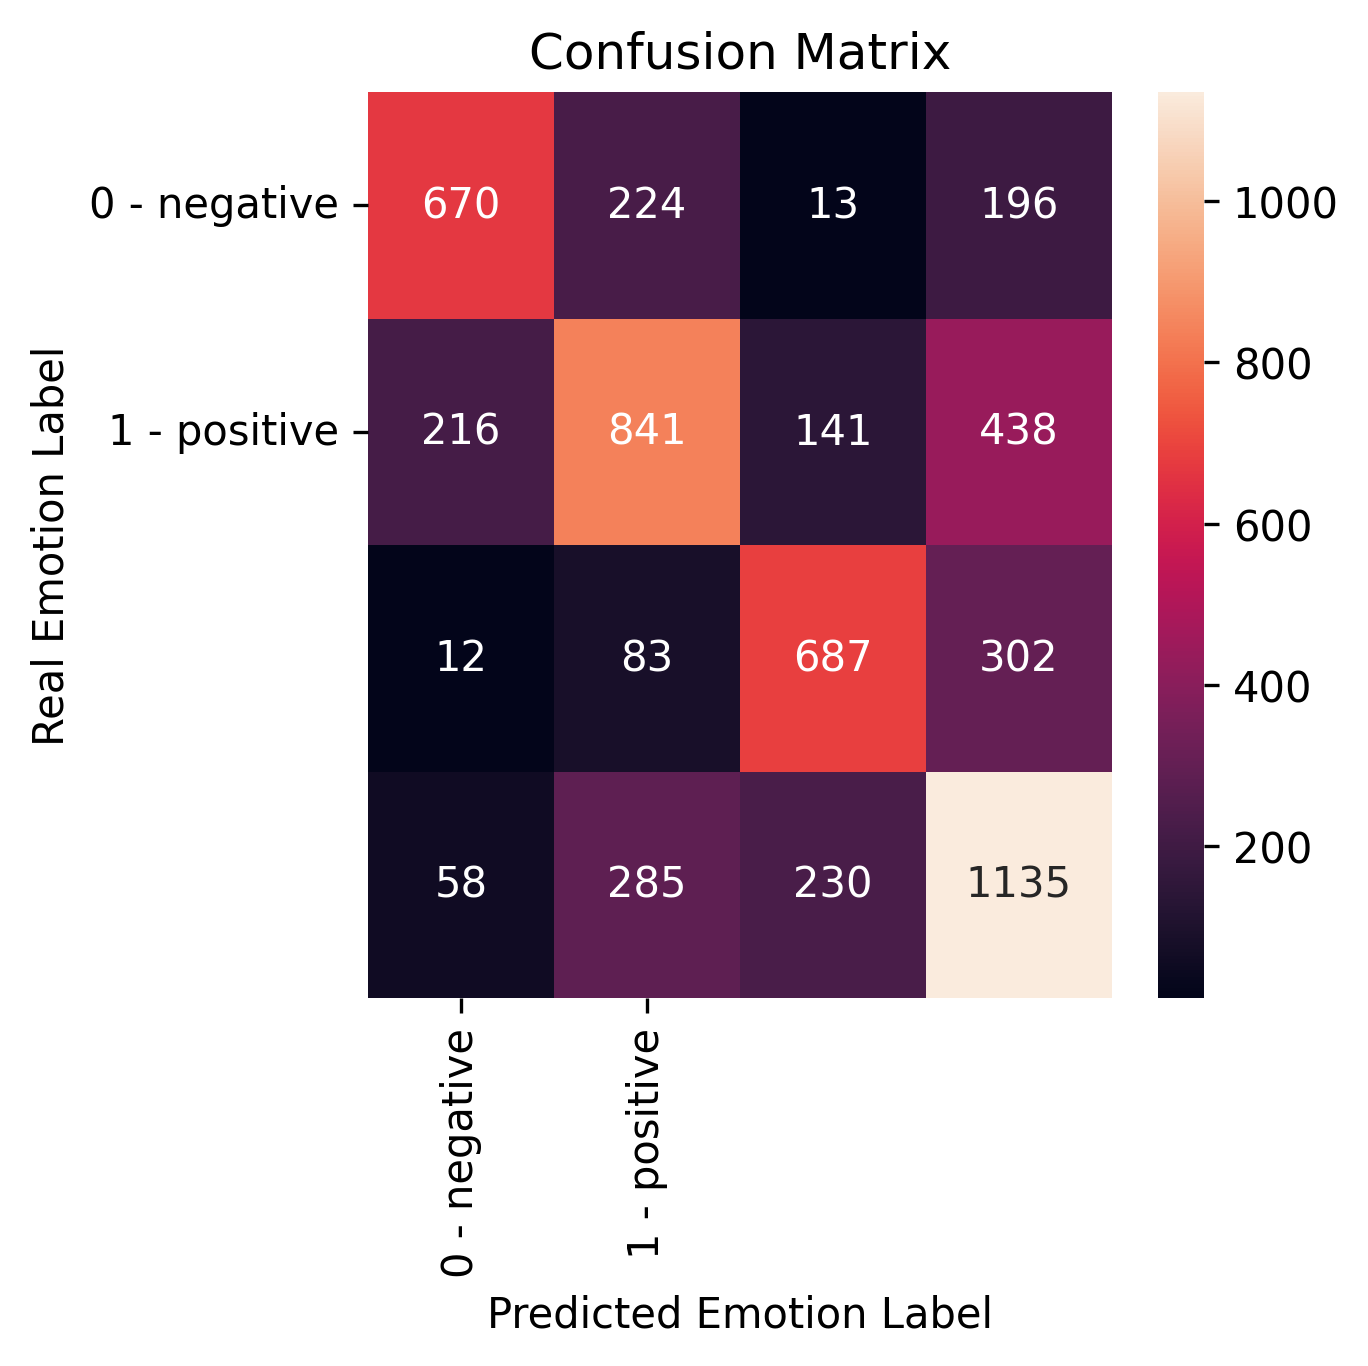

In [23]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry+Sad, Neutral+Happy+Excited", results)

Angry+Sad, Neutral+Happy+Excited

Number of Audio Files: 5531
                   Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
excited 1             1041
happy   1              595
neutral 1             1708
sad     0             1084
Accuracy for fold 0: 73.8%
Accuracy for fold 1: 74.05%
Accuracy for fold 2: 74.5%
Accuracy for fold 3: 75.14%
Accuracy for fold 4: 72.15%

Metric             Value
-----------------  ----------
Accuracy           73.93+-1.0
F1 score macro     71.34
Precision          73.43
Recall             70.73
Matthews corrcoef  0.441


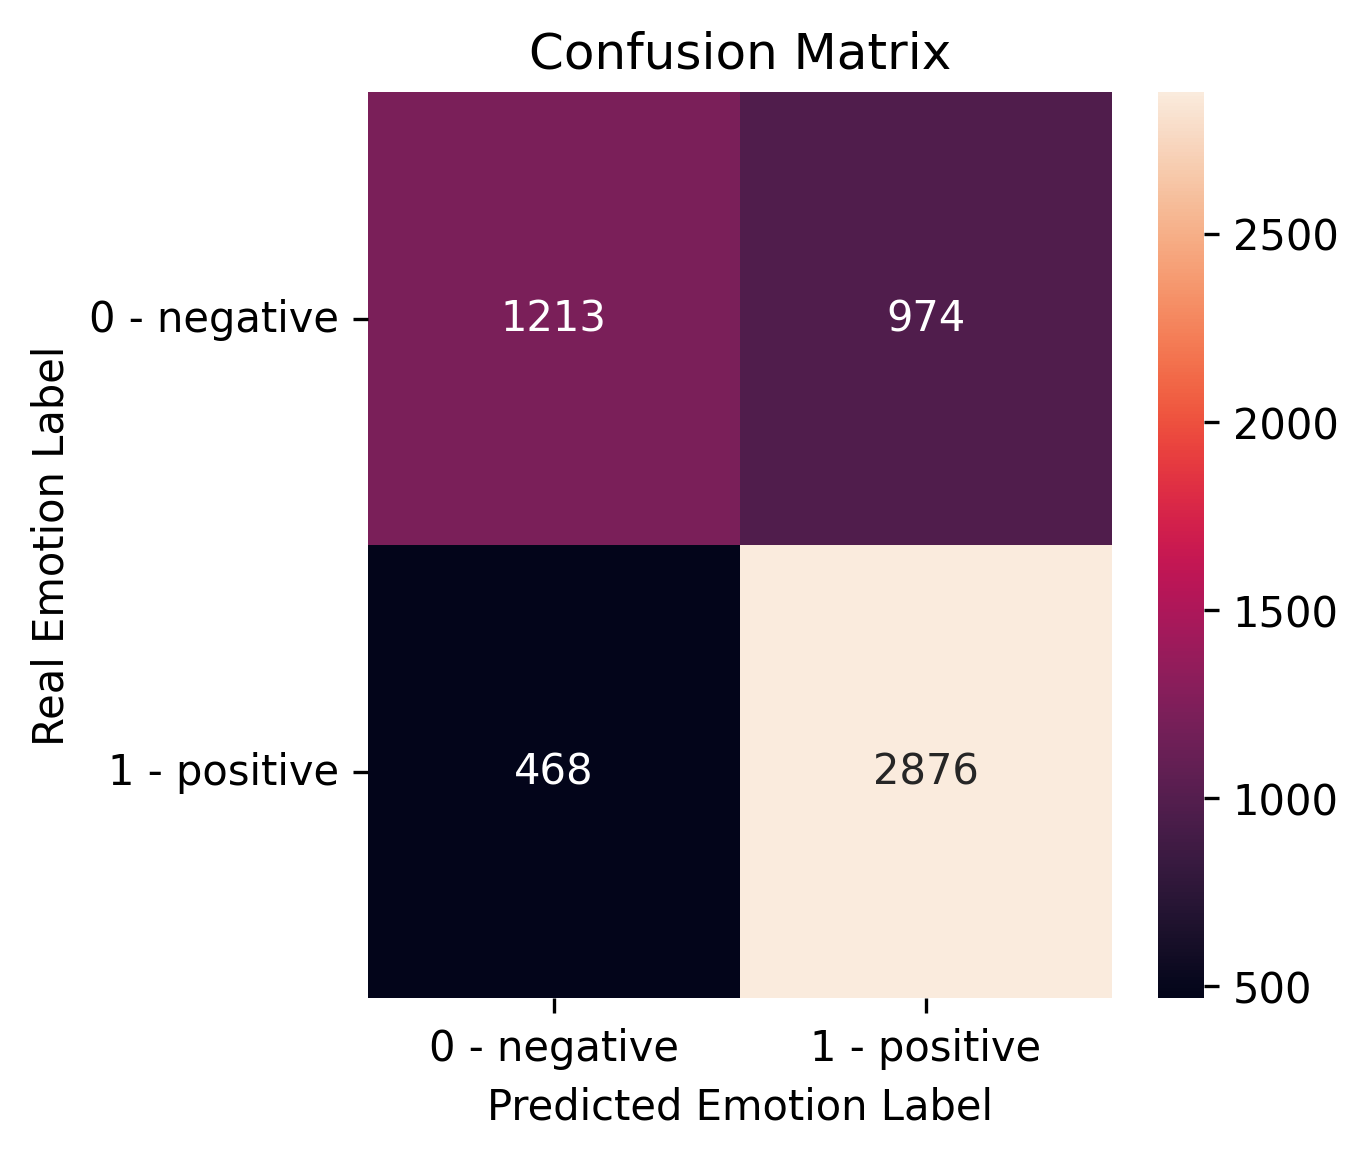

In [3]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry+Sad, Neutral+Happy+Excited", results)

Angry, Happy+Excited, Sad

Number of Audio Files: 3823
                   Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
excited 1             1041
happy   1              595
sad     2             1084
Accuracy for fold 0: 72.68%
Accuracy for fold 1: 73.59%
Accuracy for fold 2: 70.98%
Accuracy for fold 3: 69.24%
Accuracy for fold 4: 73.3%

Metric             Value
-----------------  -----------
Accuracy           71.96+-1.63
F1 score macro     72.22
Precision          72.81
Recall             71.95
Matthews corrcoef  0.569


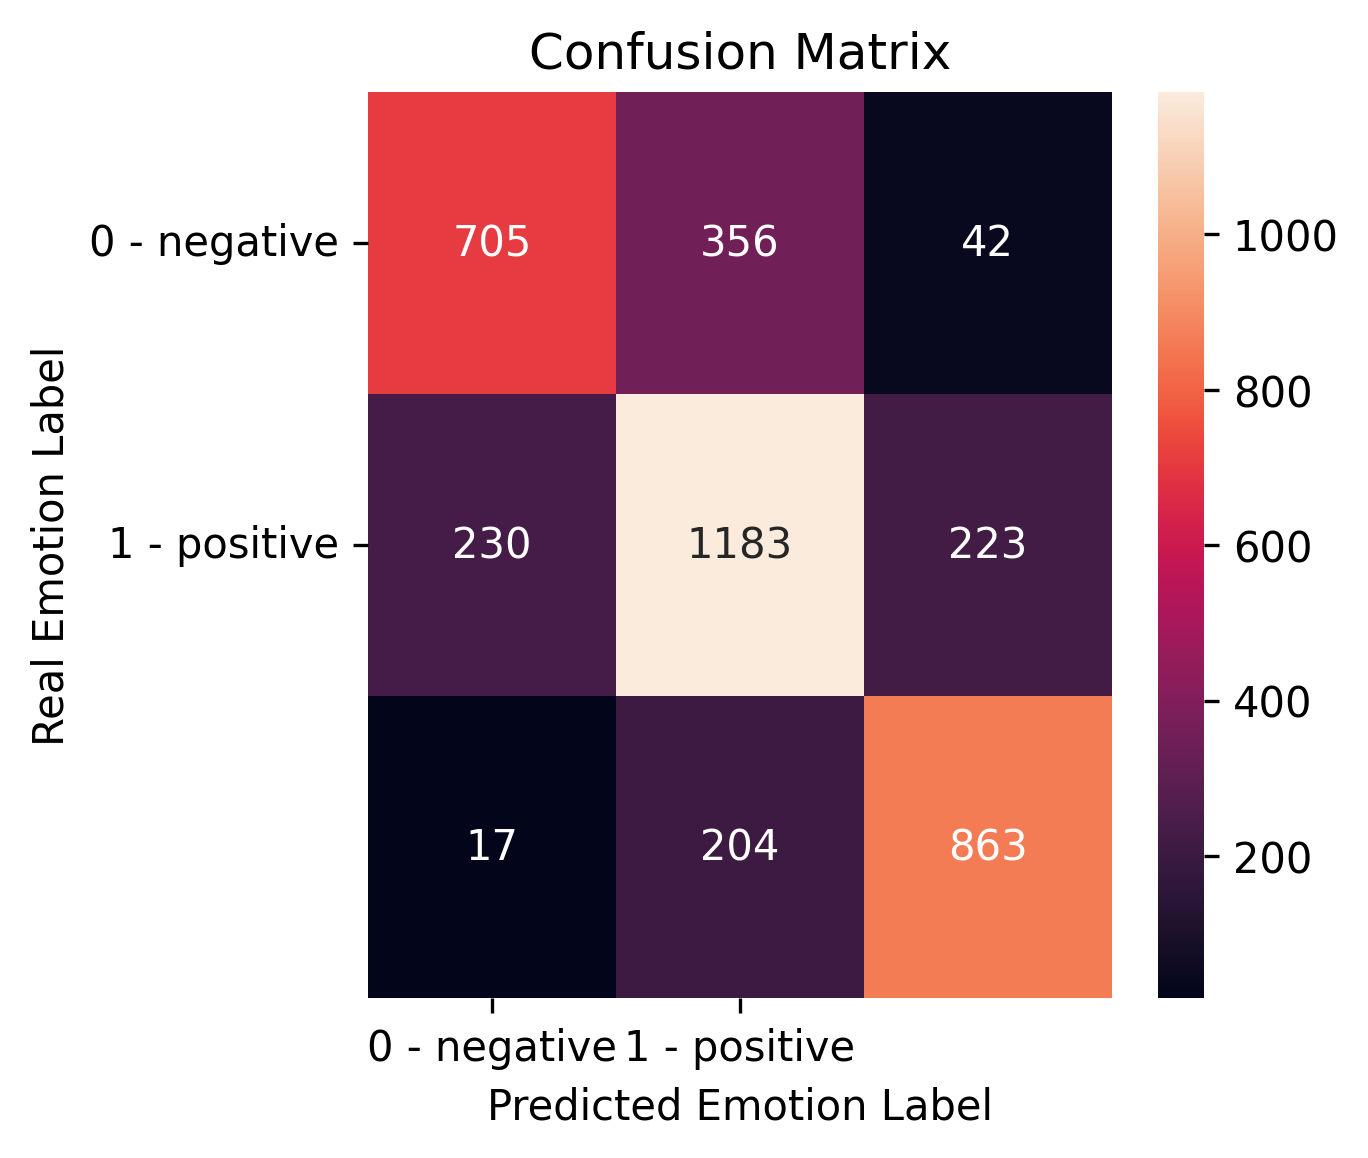

In [4]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry',  'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry, Happy+Excited, Sad", results)

Angry, Happy+Excited, Neutral

Number of Audio Files: 4447
                   Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
excited 1             1041
happy   1              595
neutral 2             1708
Accuracy for fold 0: 64.38%
Accuracy for fold 1: 64.61%
Accuracy for fold 2: 63.44%
Accuracy for fold 3: 65.02%
Accuracy for fold 4: 68.05%

Metric             Value
-----------------  ----------
Accuracy           65.1+-1.56
F1 score macro     64.77
Precision          66.03
Recall             64.52
Matthews corrcoef  0.467


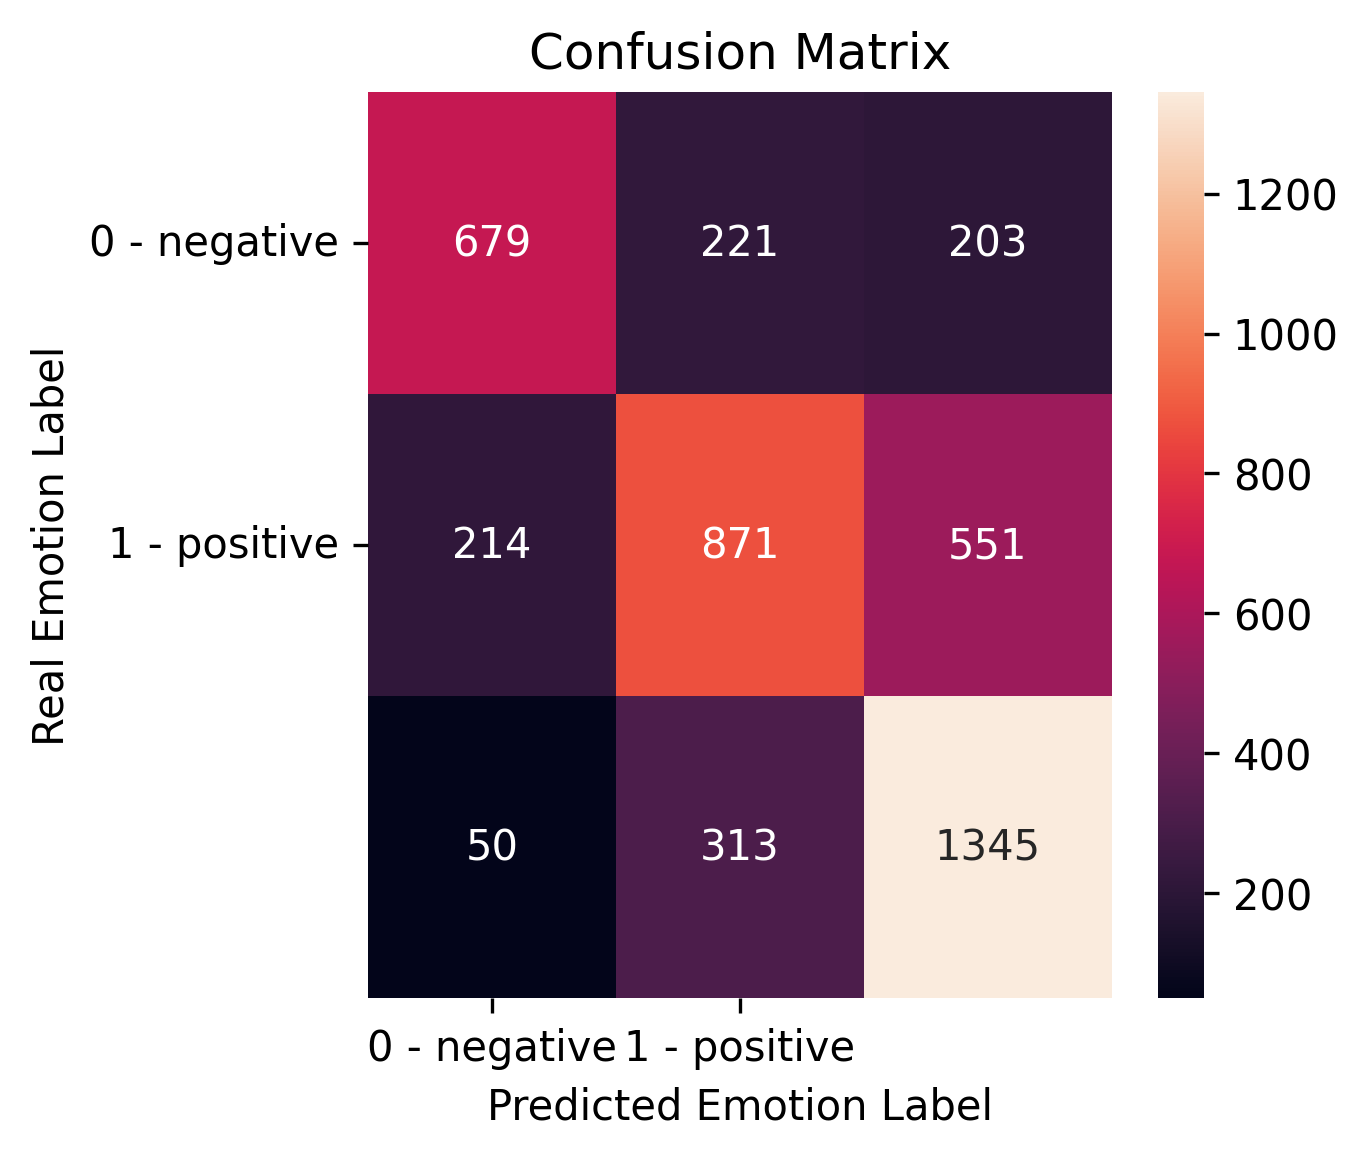

In [5]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 2
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry, Happy+Excited, Neutral", results)

Sad, Happy+Excited, Neutral

Number of Audio Files: 4428
                   Emotion
                     count
Emotion Emotion_Id        
excited 1             1041
happy   1              595
neutral 2             1708
sad     0             1084
Accuracy for fold 0: 63.32%
Accuracy for fold 1: 62.42%
Accuracy for fold 2: 68.51%
Accuracy for fold 3: 63.62%
Accuracy for fold 4: 64.07%

Metric             Value
-----------------  -----------
Accuracy           64.39+-2.13
F1 score macro     64.39
Precision          64.91
Recall             64.17
Matthews corrcoef  0.456


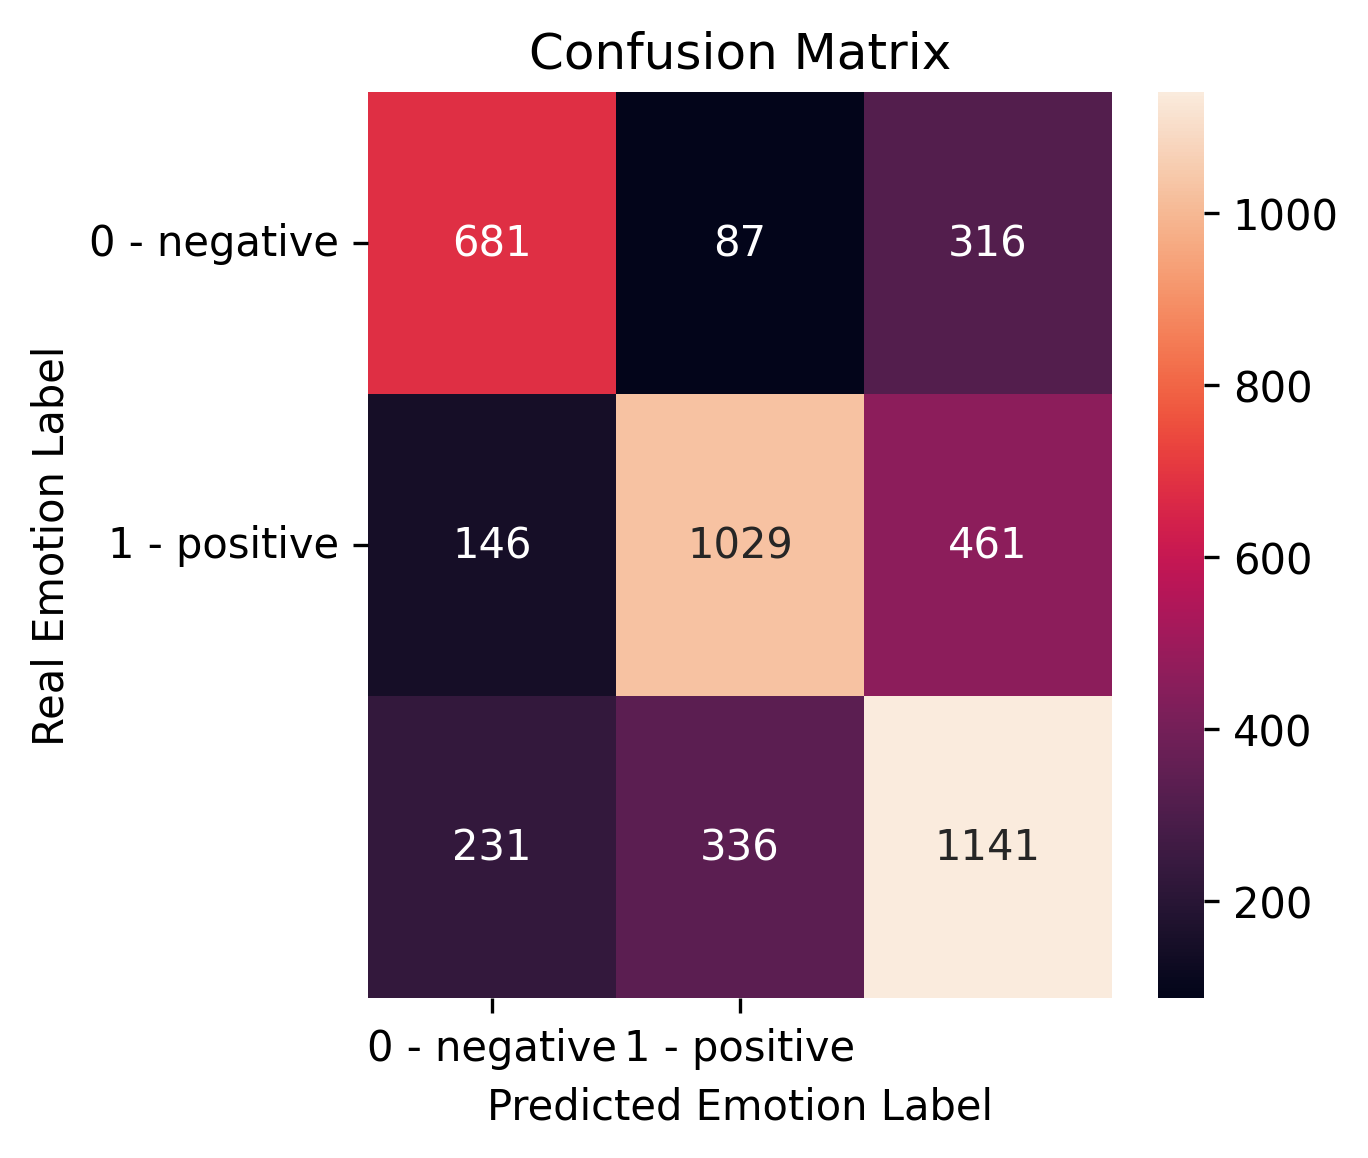

In [6]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'sad', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 2

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Sad, Happy+Excited, Neutral", results)

Angry, Sad, Neutral

Number of Audio Files: 3895
                   Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
neutral 1             1708
sad     2             1084
Accuracy for fold 0: 72.53%
Accuracy for fold 1: 73.94%
Accuracy for fold 2: 73.17%
Accuracy for fold 3: 76.12%
Accuracy for fold 4: 73.3%

Metric             Value
-----------------  -----------
Accuracy           73.81+-1.24
F1 score macro     73.87
Precision          75.81
Recall             72.7
Matthews corrcoef  0.594


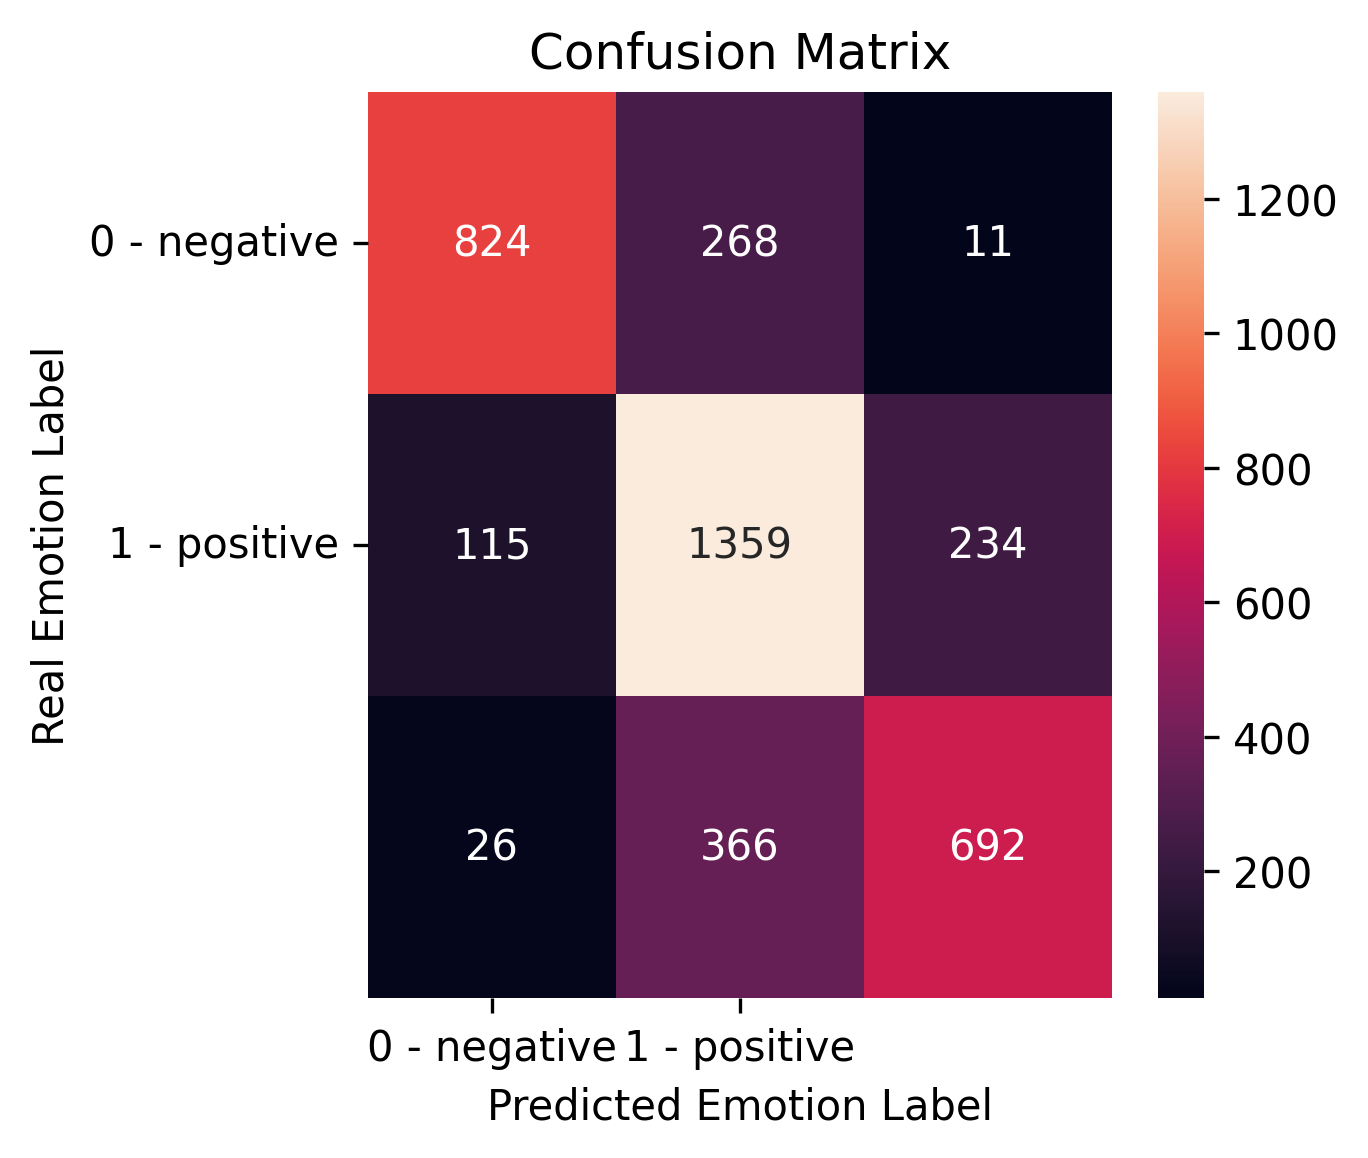

In [7]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'sad'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry, Sad, Neutral", results)

Angry+Sad, Happy+Excited

Number of Audio Files: 3823
                   Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
excited 1             1041
happy   1              595
sad     0             1084
Accuracy for fold 0: 76.21%
Accuracy for fold 1: 75.95%
Accuracy for fold 2: 74.25%
Accuracy for fold 3: 74.48%
Accuracy for fold 4: 75.26%

Metric             Value
-----------------  -----------
Accuracy           75.23+-0.77
F1 score macro     74.22
Precision          75.0
Recall             73.91
Matthews corrcoef  0.489


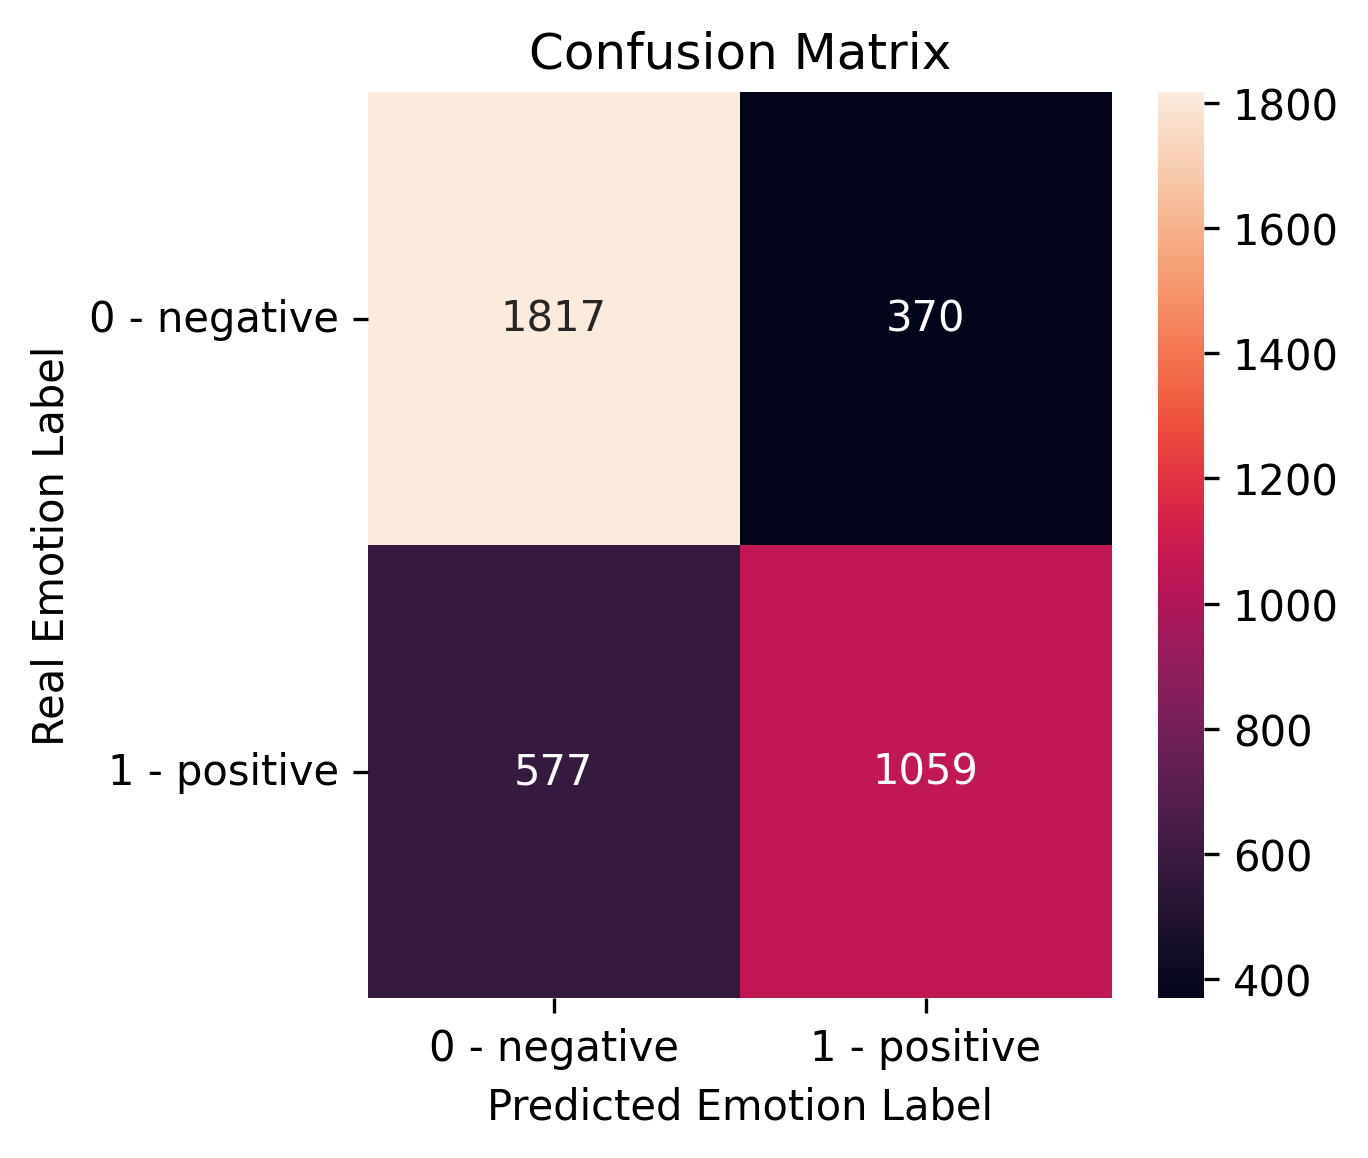

In [8]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry+Sad, Happy+Excited", results)

Angry+Sad, Happy+Excited, Neutral

Number of Audio Files: 5531
                   Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
excited 1             1041
happy   1              595
neutral 2             1708
sad     0             1084
Accuracy for fold 0: 59.98%
Accuracy for fold 1: 63.11%
Accuracy for fold 2: 59.86%
Accuracy for fold 3: 61.48%
Accuracy for fold 4: 60.94%

Metric             Value
-----------------  -----------
Accuracy           61.07+-1.18
F1 score macro     60.16
Precision          60.59
Recall             60.18
Matthews corrcoef  0.41


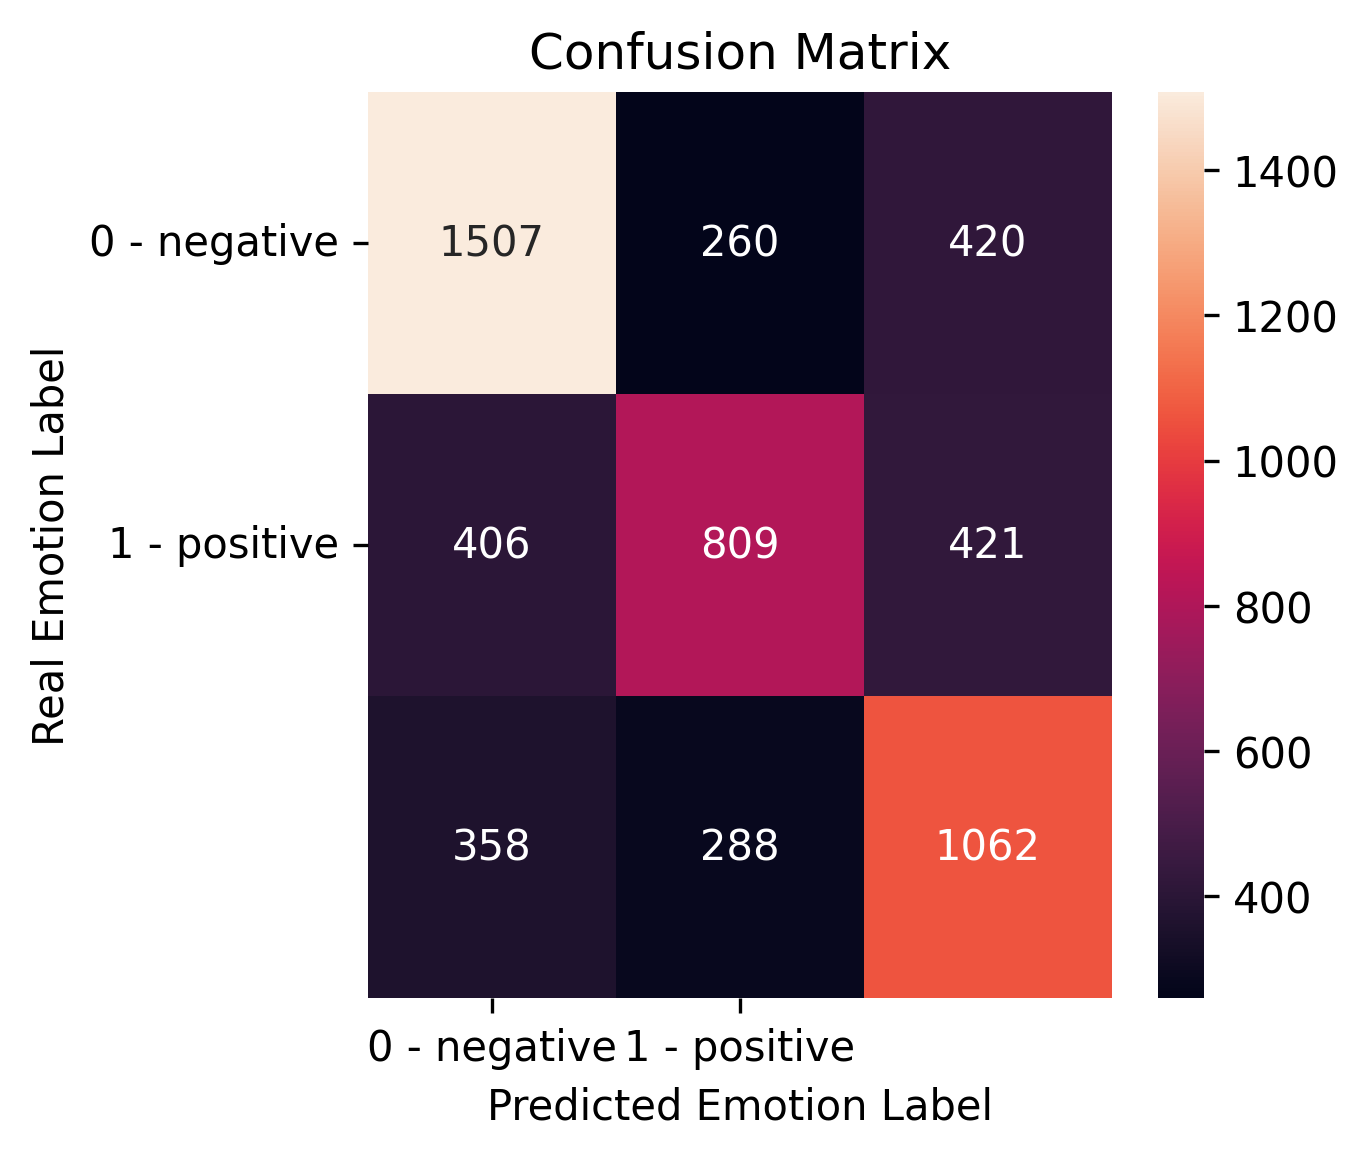

In [9]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 2
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry+Sad, Happy+Excited, Neutral", results)

Angry, Sad

Number of Audio Files: 2187
                   Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
sad     1             1084
Accuracy for fold 0: 91.32%
Accuracy for fold 1: 91.78%
Accuracy for fold 2: 93.59%
Accuracy for fold 3: 93.14%
Accuracy for fold 4: 90.39%

Metric             Value
-----------------  -----------
Accuracy           92.04+-1.18
F1 score macro     92.04
Precision          92.05
Recall             92.04
Matthews corrcoef  0.841


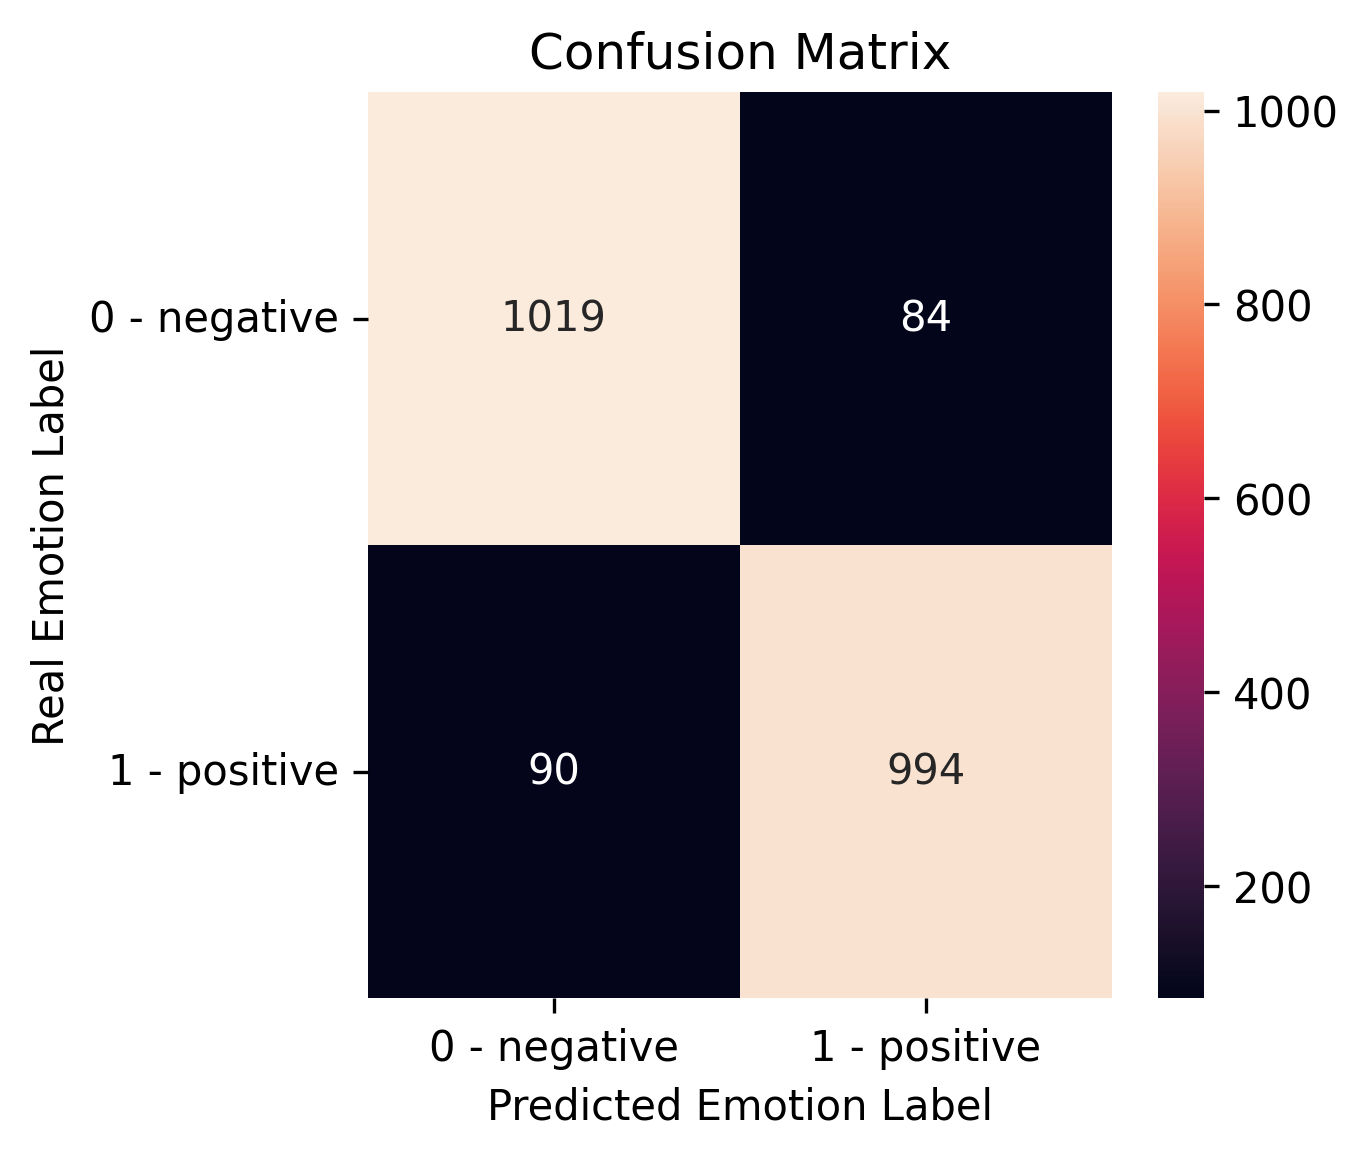

In [10]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry, Sad", results)

Angry, Neutral

Number of Audio Files: 2811
                   Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
neutral 1             1708
Accuracy for fold 0: 83.48%
Accuracy for fold 1: 85.77%
Accuracy for fold 2: 85.59%
Accuracy for fold 3: 87.01%
Accuracy for fold 4: 86.3%

Metric             Value
-----------------  -----------
Accuracy           85.63+-1.18
F1 score macro     84.42
Precision          86.18
Recall             83.5
Matthews corrcoef  0.696


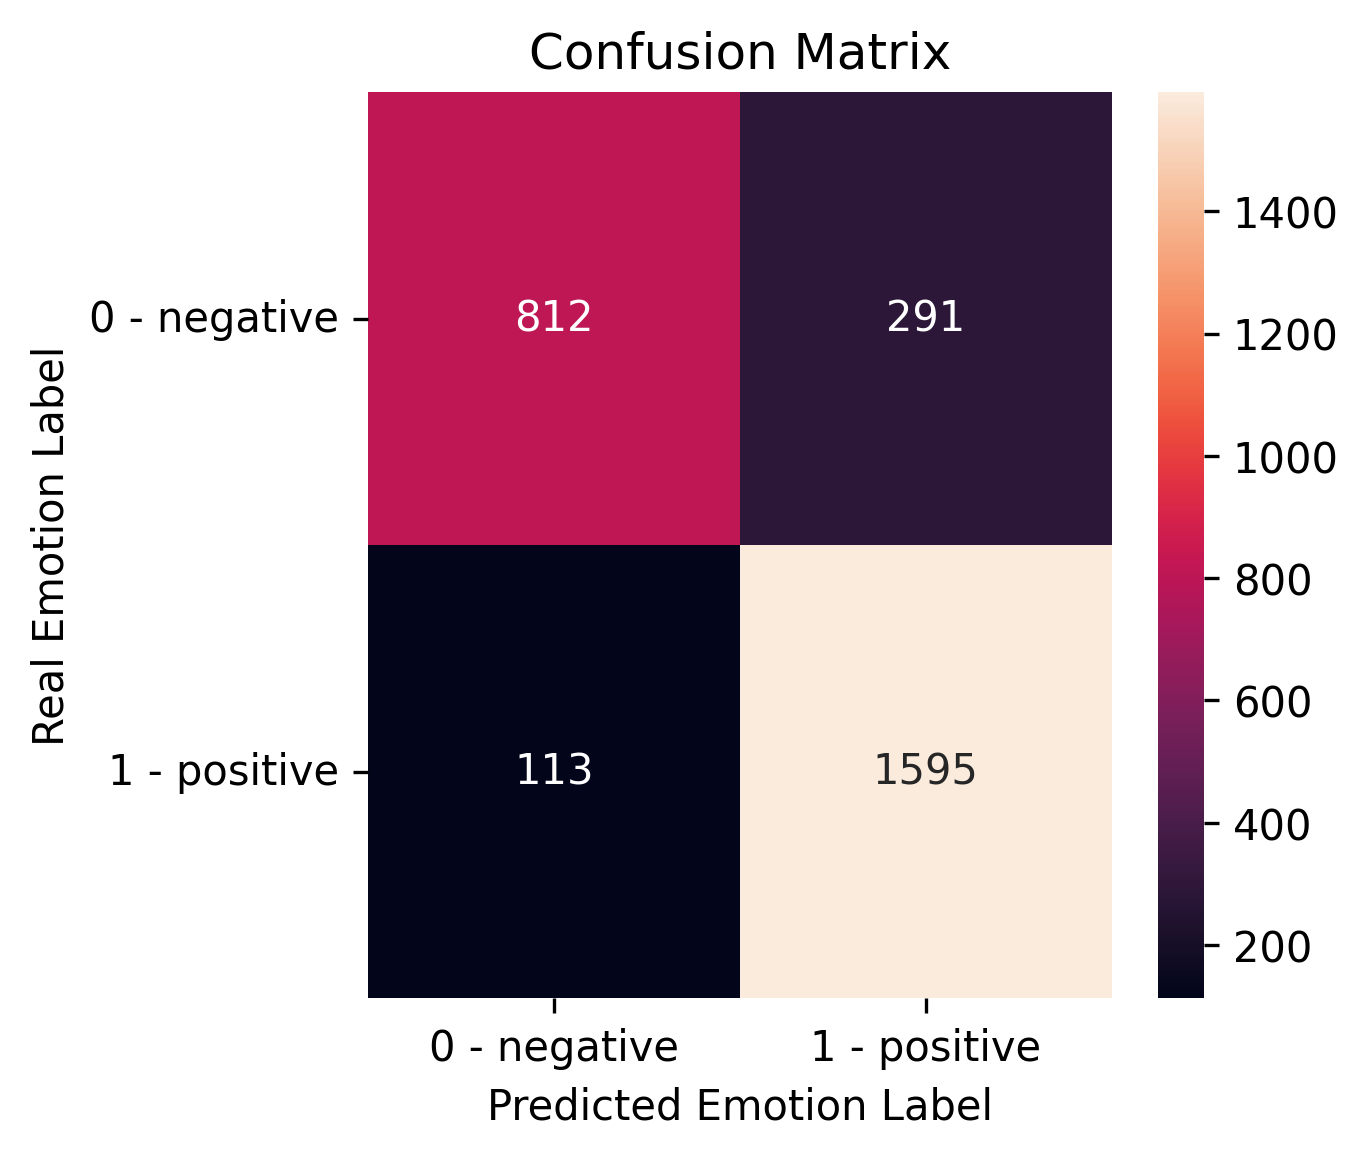

In [11]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry, Neutral", results)

Angry, Happy+Excited

Number of Audio Files: 2739
                   Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
excited 1             1041
happy   1              595
Accuracy for fold 0: 73.91%
Accuracy for fold 1: 77.92%
Accuracy for fold 2: 78.1%
Accuracy for fold 3: 75.18%
Accuracy for fold 4: 78.79%

Metric             Value
-----------------  -----------
Accuracy           76.78+-1.89
F1 score macro     75.32
Precision          76.17
Recall             74.88
Matthews corrcoef  0.51


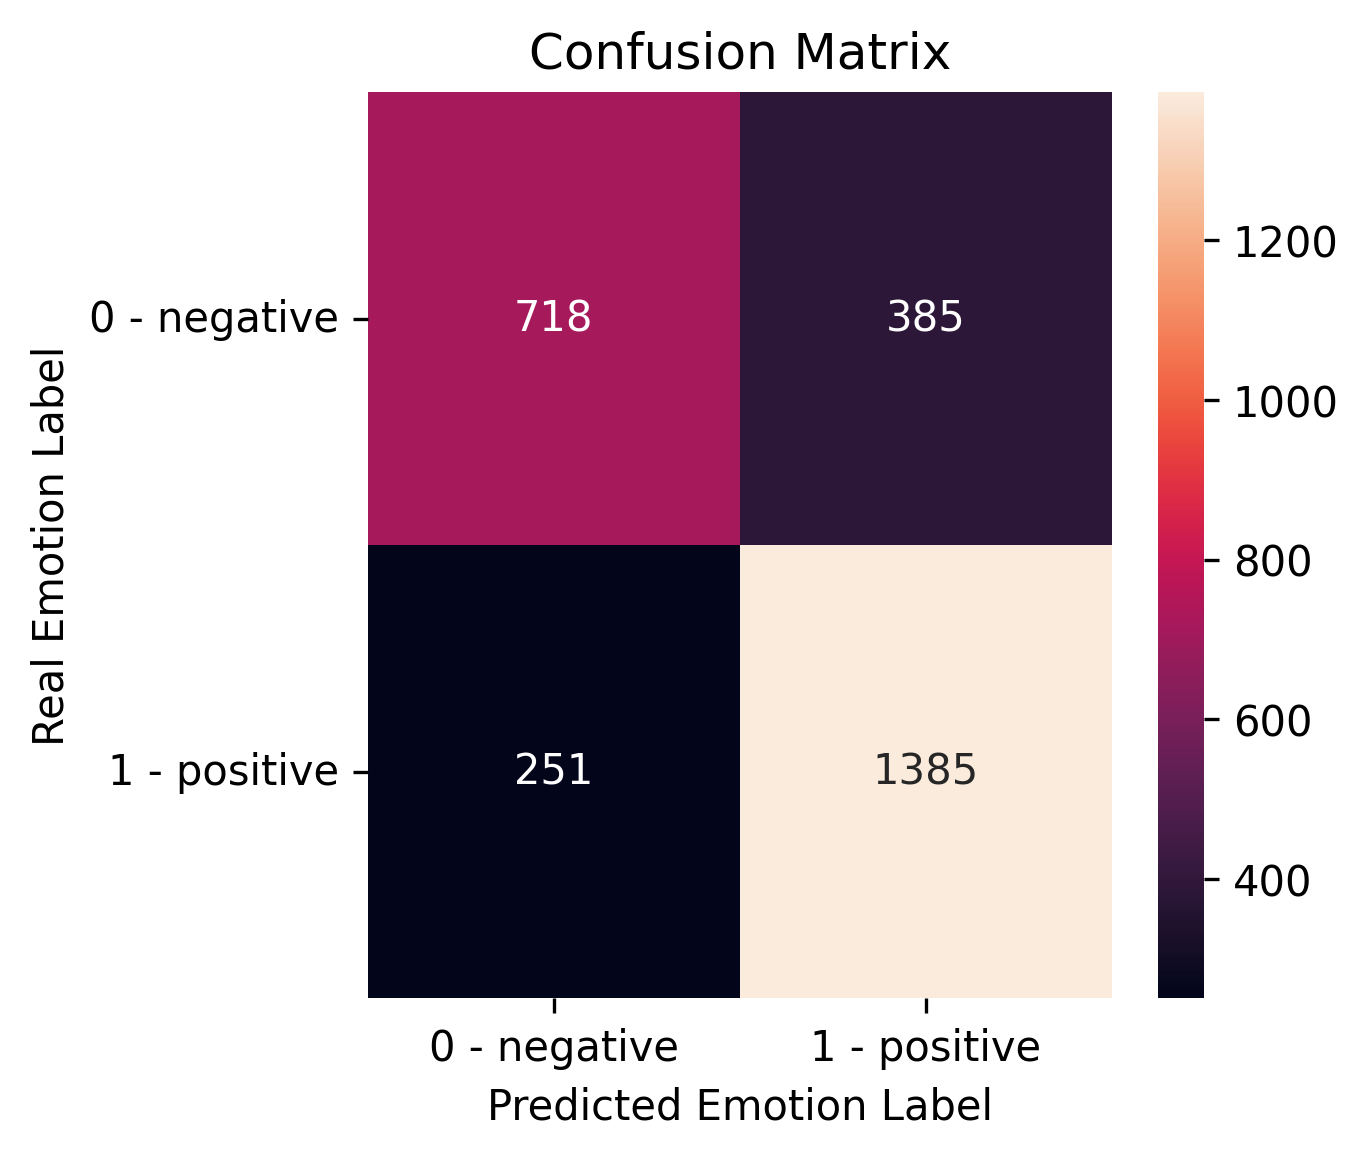

In [12]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry+Sad, Happy+Excited", results)

Sad, Neutral

Number of Audio Files: 2792
                   Emotion
                     count
Emotion Emotion_Id        
neutral 1             1708
sad     0             1084
Accuracy for fold 0: 78.0%
Accuracy for fold 1: 76.57%
Accuracy for fold 2: 78.14%
Accuracy for fold 3: 78.49%
Accuracy for fold 4: 79.21%

Metric             Value
-----------------  -----------
Accuracy           78.08+-0.86
F1 score macro     76.34
Precision          77.3
Recall             75.8
Matthews corrcoef  0.531


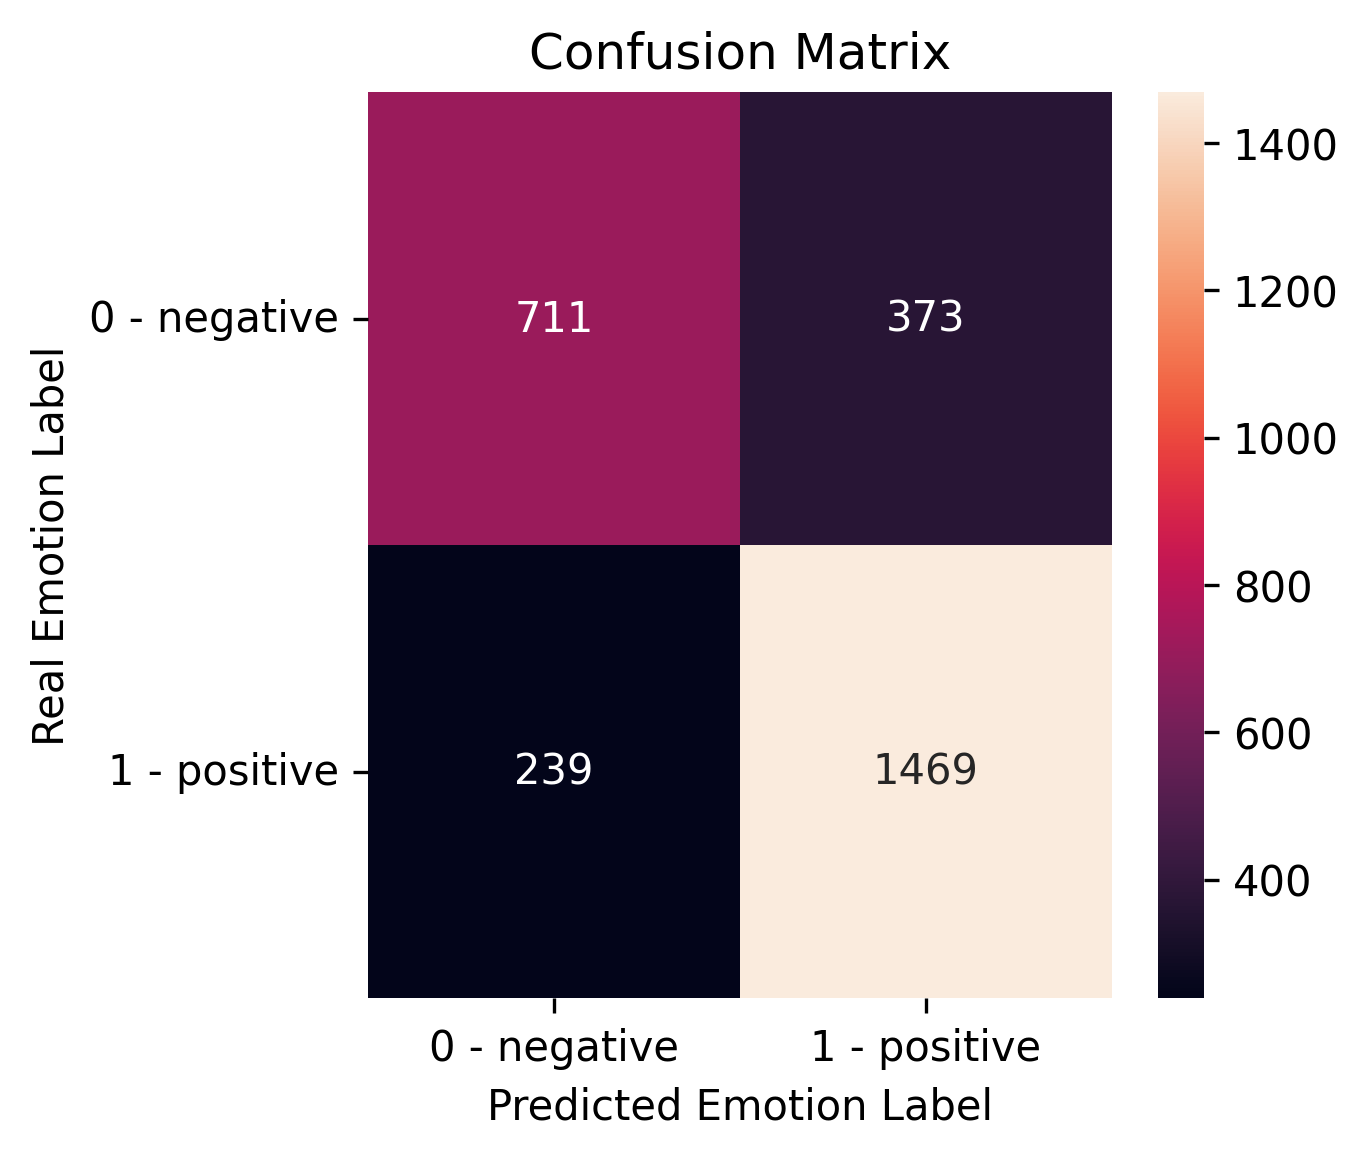

In [13]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'sad', 'neutral'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Sad, Neutral", results)

Sad, Happy+Excited

Number of Audio Files: 2720
                   Emotion
                     count
Emotion Emotion_Id        
excited 1             1041
happy   1              595
sad     0             1084
Accuracy for fold 0: 82.72%
Accuracy for fold 1: 83.64%
Accuracy for fold 2: 86.76%
Accuracy for fold 3: 81.99%
Accuracy for fold 4: 84.56%

Metric             Value
-----------------  -----------
Accuracy           83.93+-1.66
F1 score macro     83.27
Precision          83.22
Recall             83.33
Matthews corrcoef  0.665


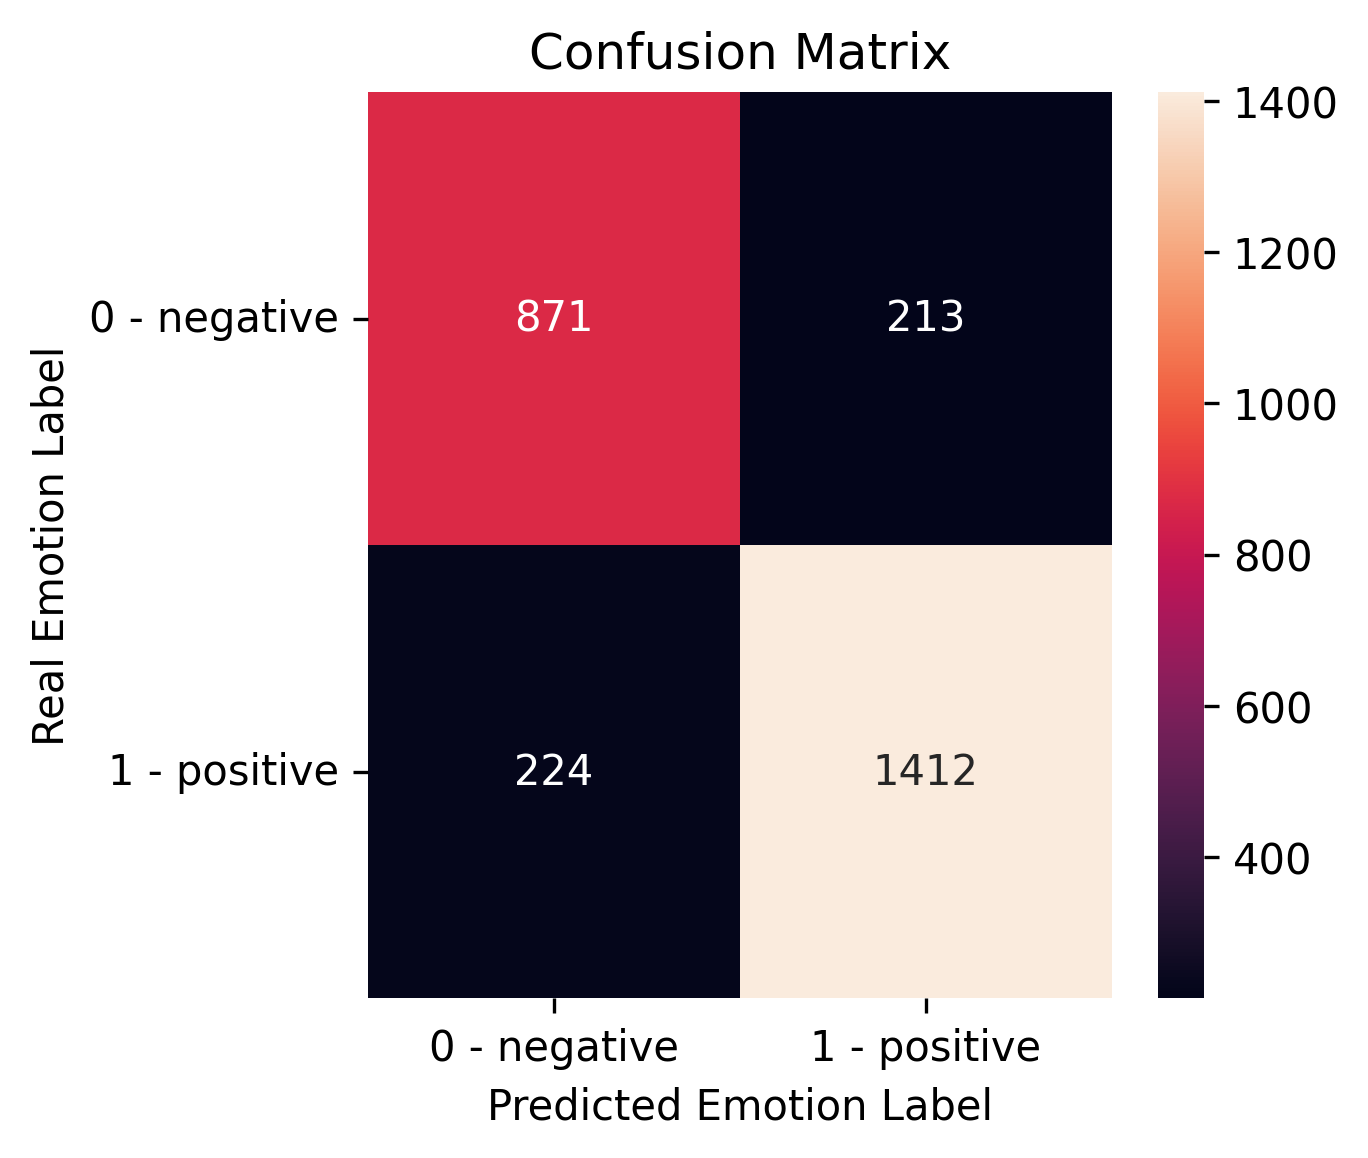

In [14]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'sad', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Sad, Happy+Excited", results)

Neutral, Happy+Excited

Number of Audio Files: 3344
                   Emotion
                     count
Emotion Emotion_Id        
excited 1             1041
happy   1              595
neutral 0             1708
Accuracy for fold 0: 72.05%
Accuracy for fold 1: 72.8%
Accuracy for fold 2: 73.39%
Accuracy for fold 3: 71.3%
Accuracy for fold 4: 73.05%

Metric             Value
-----------------  -----------
Accuracy           72.52+-0.75
F1 score macro     72.32
Precision          72.85
Recall             72.37
Matthews corrcoef  0.452


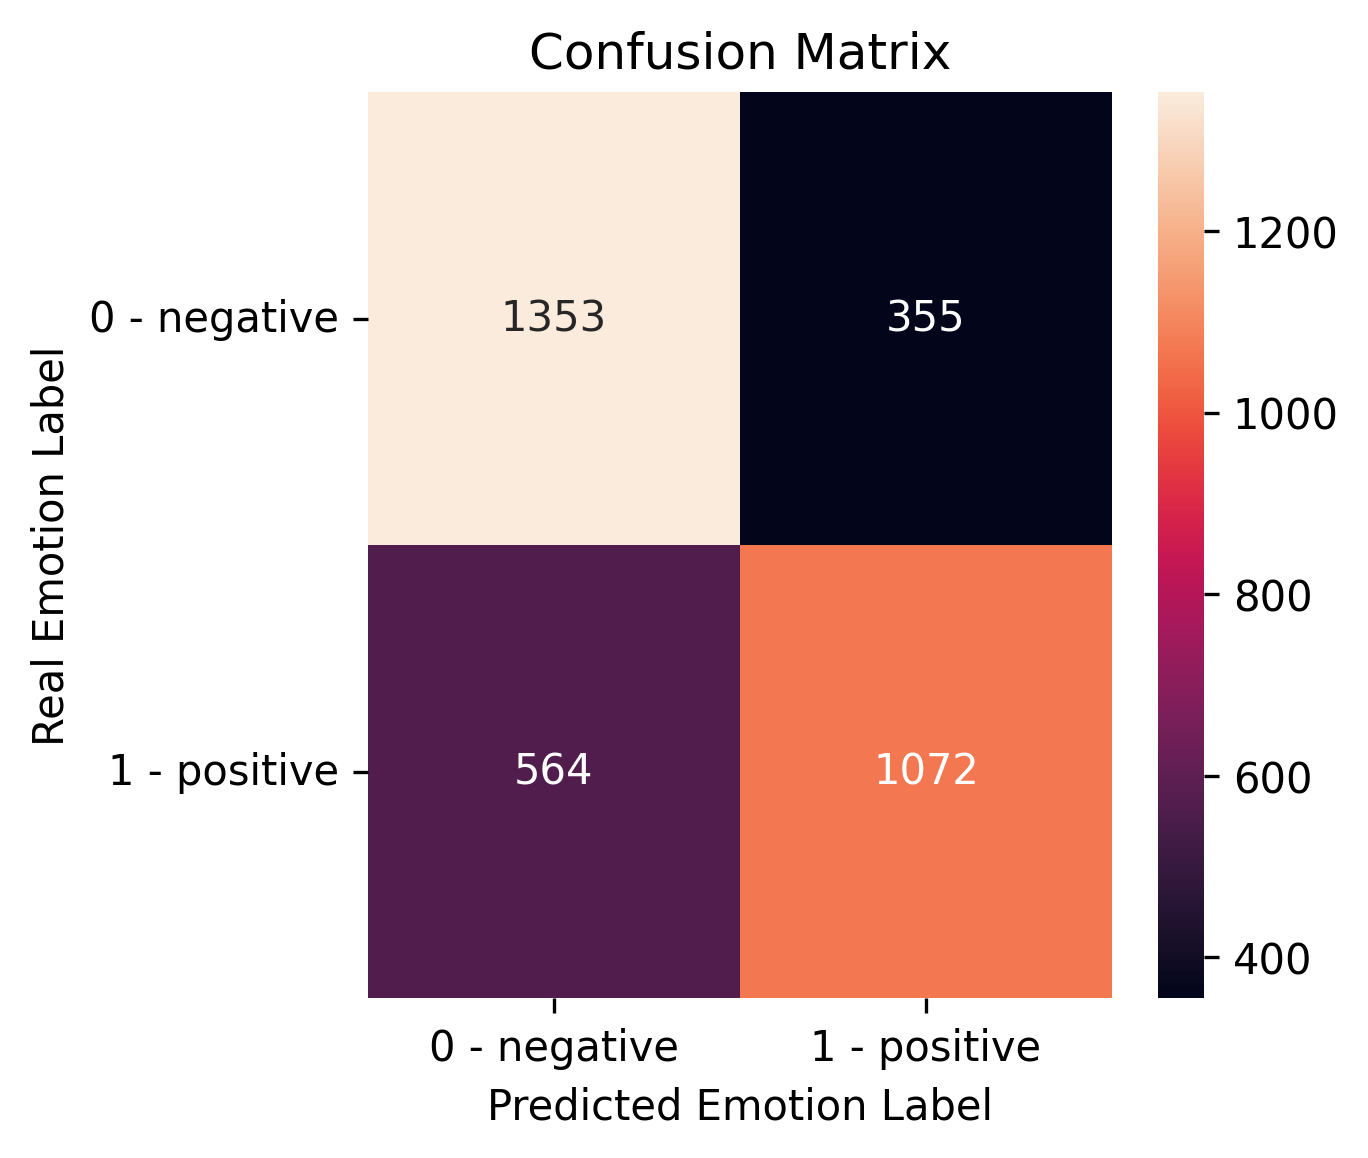

In [15]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Neutral, Happy+Excited", results)

Results

In [16]:
print(tabulate(results, headers=["Classification Labels", "Accuracy"]))

Classification Labels              Accuracy
---------------------------------  -----------
Angry+Sad, Neutral+Happy+Excited   73.93+-1.0
Angry, Happy+Excited, Sad          71.96+-1.63
Angry, Happy+Excited, Neutral      65.1+-1.56
Sad, Happy+Excited, Neutral        64.39+-2.13
Angry, Sad, Neutral                73.81+-1.24
Angry+Sad, Happy+Excited           75.23+-0.77
Angry+Sad, Happy+Excited, Neutral  61.07+-1.18
Angry+Sad, Happy+Excited, Neutral  92.04+-1.18
Angry+Sad, Happy+Excited, Neutral  85.63+-1.18
Angry+Sad, Happy+Excited, Neutral  76.78+-1.89
Angry+Sad, Happy+Excited, Neutral  78.08+-0.86
Angry+Sad, Happy+Excited, Neutral  83.93+-1.66
Angry+Sad, Happy+Excited, Neutral  72.52+-0.75


# Neutral Data Analysis

## Duration

In [16]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.groupby(['Emotion']).agg({'Duration': ['describe']})

Duration                                                           \
        describe                                                            
           count      mean       std     min       25%      50%       75%   
Emotion                                                                     
angry     1103.0  4.512970  3.006933  0.7600  2.435300  3.61050  5.660000   
excited   1041.0  4.780933  3.468133  0.5850  2.346100  3.82000  6.210000   
happy      595.0  4.341335  2.719494  0.8950  2.398850  3.56000  5.800000   
neutral   1708.0  3.901985  2.584867  0.7300  2.109975  3.13000  4.911875   
sad       1084.0  5.496464  4.040116  0.7642  2.680000  4.14675  7.013600   

                  
                  
             max  
Emotion           
angry    26.7730  
excited  34.1388  
happy    17.2237  
neutral  20.2900  
sad      31.9100

In [19]:
df = df[(df['Emotion_Id'] != 3) | (df["Duration"] > 1.7)]
df.groupby(['Emotion']).agg({'Duration': ['describe']})

Duration                                                        \
        describe                                                         
           count      mean       std     min      25%      50%     75%   
Emotion                                                                  
angry     1103.0  4.512970  3.006933  0.7600  2.43530  3.61050  5.6600   
excited   1041.0  4.780933  3.468133  0.5850  2.34610  3.82000  6.2100   
happy      595.0  4.341335  2.719494  0.8950  2.39885  3.56000  5.8000   
neutral   1453.0  4.347335  2.553059  1.7000  2.54540  3.53000  5.4423   
sad       1084.0  5.496464  4.040116  0.7642  2.68000  4.14675  7.0136   

                  
                  
             max  
Emotion           
angry    26.7730  
excited  34.1388  
happy    17.2237  
neutral  20.2900  
sad      31.9100

Neutral Data with more than 1.7 seconds of audio

Number of Audio Files: 5276
                   Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
excited 1             1041
happy   1              595
neutral 3             1453
sad     2             1084
Accuracy for fold 0: 59.66%
Accuracy for fold 1: 60.28%
Accuracy for fold 2: 60.95%
Accuracy for fold 3: 58.77%
Accuracy for fold 4: 60.95%

Metric             Value
-----------------  -----------
Accuracy           60.12+-0.83
F1 score macro     60.97
Precision          61.44
Recall             60.8
Matthews corrcoef  0.463


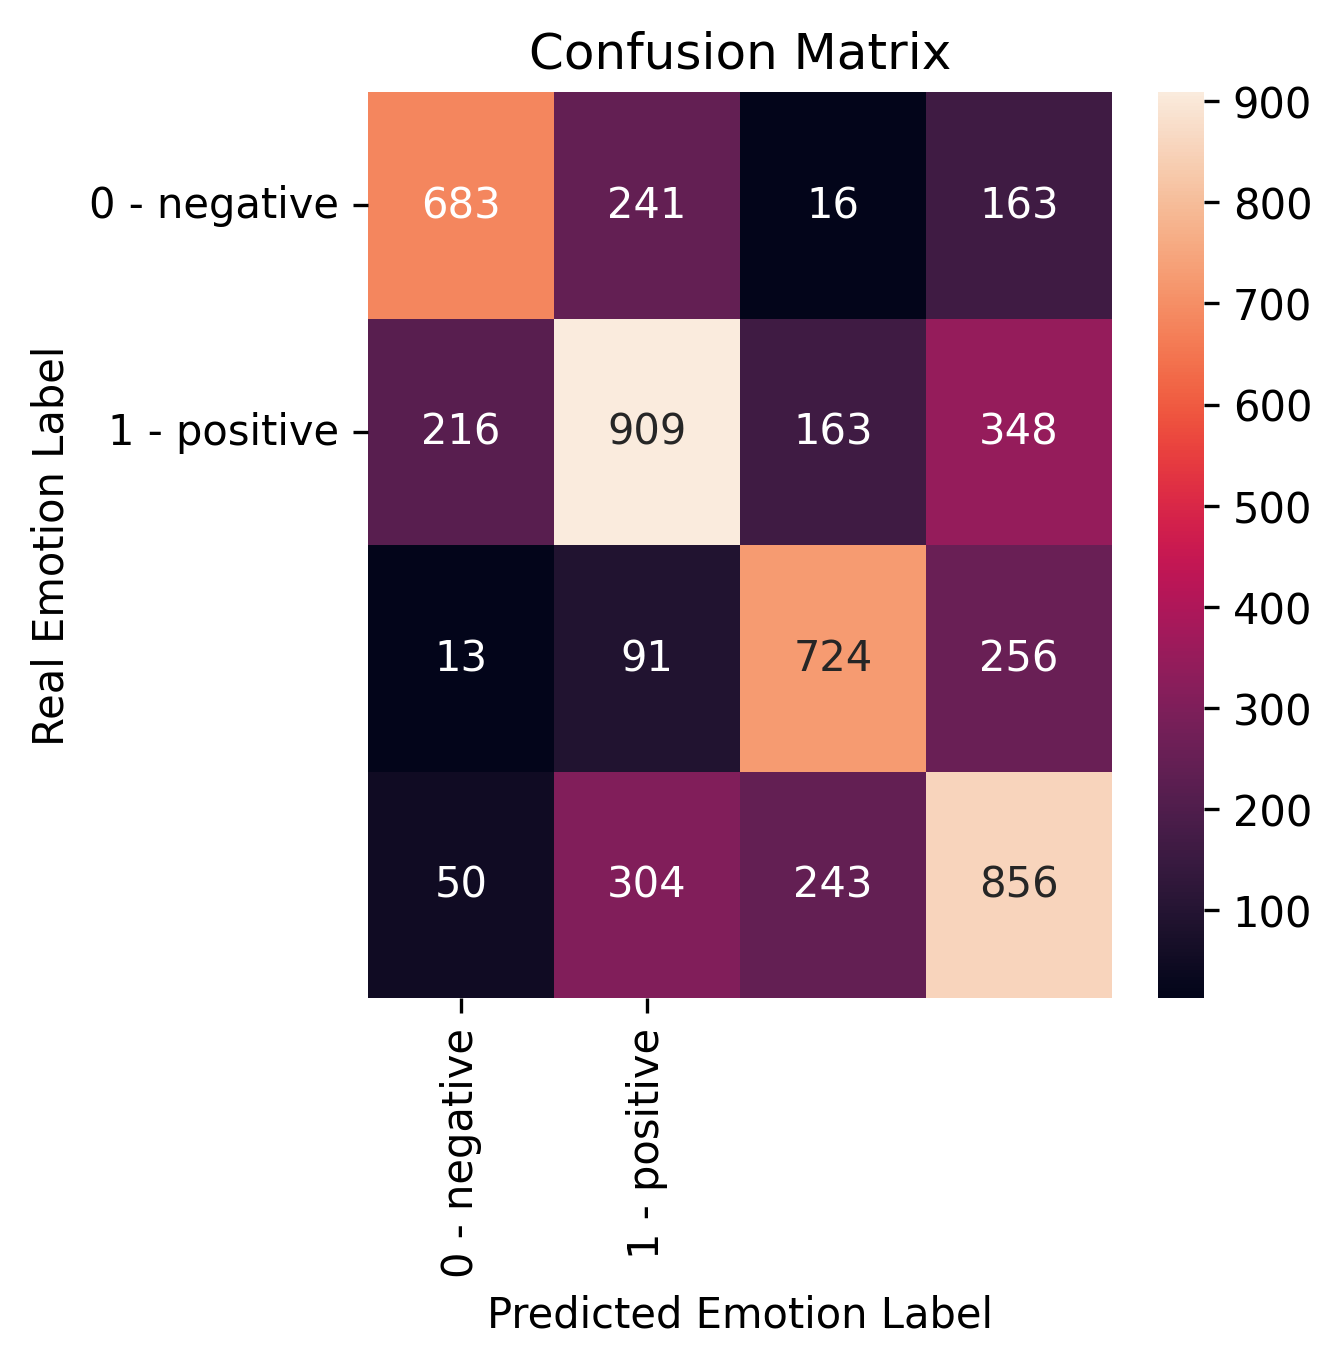

In [27]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df = df[(df['Emotion_Id'] != 3) | (df["Duration"] > 1.7)]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry+Sad, Neutral+Happy+Excited", results)

Neutral Data with more than 1 seconds of audio

Number of Audio Files: 5515
                   Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
excited 1             1041
happy   1              595
neutral 3             1692
sad     2             1084
Accuracy for fold 0: 61.92%
Accuracy for fold 1: 59.02%
Accuracy for fold 2: 60.47%
Accuracy for fold 3: 60.2%
Accuracy for fold 4: 58.02%

Metric             Value
-----------------  -----------
Accuracy           59.93+-1.33
F1 score macro     60.62
Precision          61.64
Recall             60.16
Matthews corrcoef  0.457


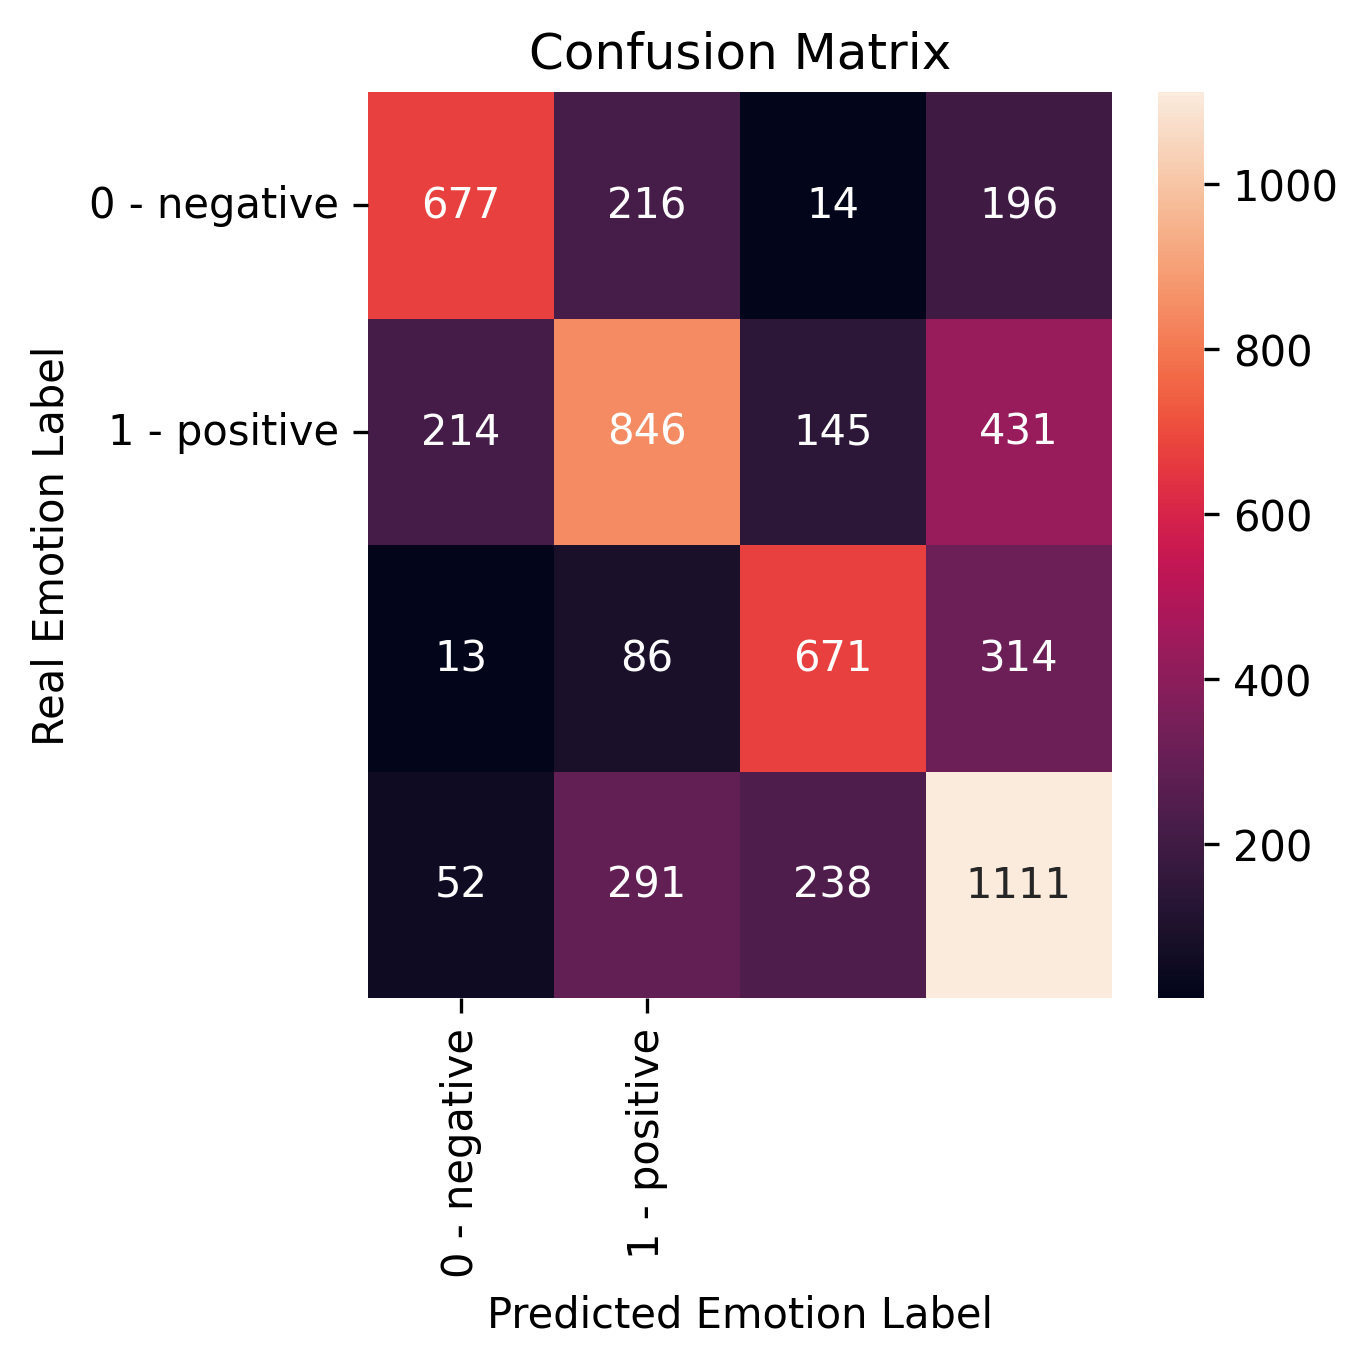

In [41]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df = df[(df['Emotion_Id'] != 3) | (df["Duration"] > 1)]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry+Sad, Neutral+Happy+Excited", results)

Data between 1.7 and 7 seconds of audio

Number of Audio Files: 4021
                   Emotion
                     count
Emotion Emotion_Id        
angry   0              848
excited 1              705
happy   1              450
neutral 3             1268
sad     2              750
Accuracy for fold 0: 62.24%
Accuracy for fold 1: 57.21%
Accuracy for fold 2: 56.72%
Accuracy for fold 3: 57.71%
Accuracy for fold 4: 56.84%

Metric             Value
-----------------  -----------
Accuracy           58.14+-2.08
F1 score macro     58.66
Precision          60.19
Recall             58.2
Matthews corrcoef  0.434


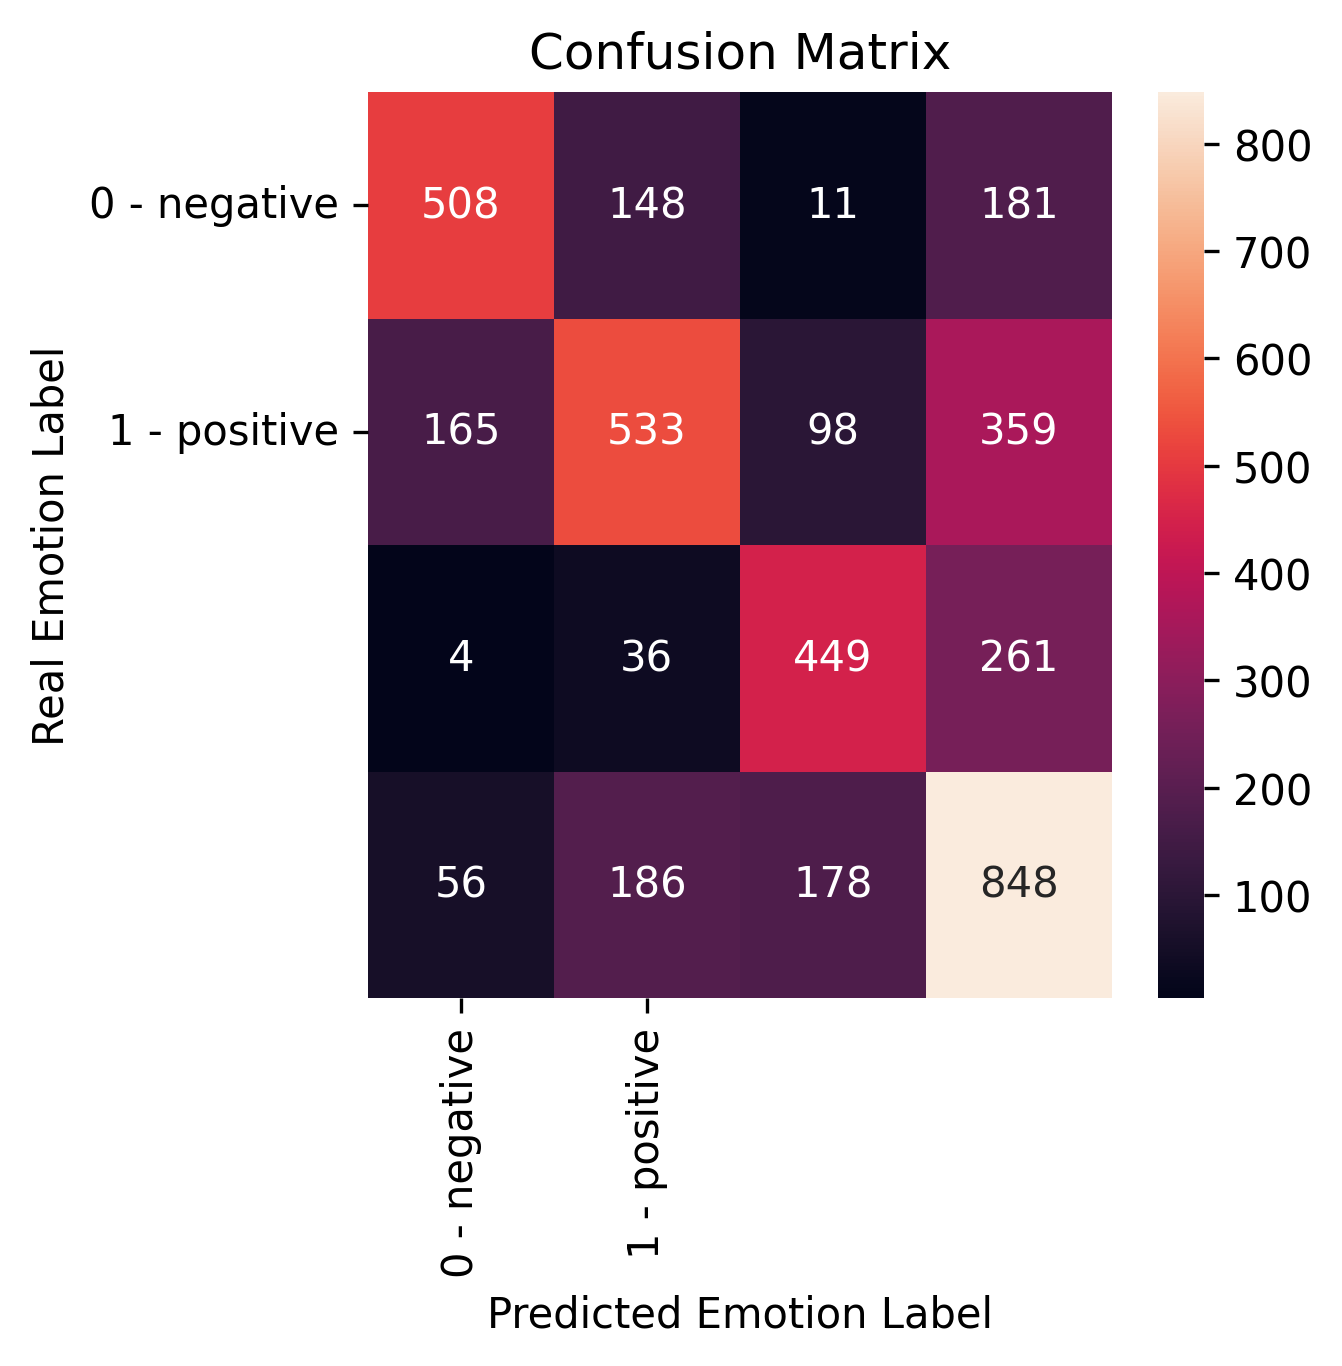

In [33]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df = df[(df["Duration"] < 7) & (df["Duration"] > 1.7)]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry+Sad, Neutral+Happy+Excited", results)

Data between 1.7 and 8 seconds of audio

Number of Audio Files: 4257
                   Emotion
                     count
Emotion Emotion_Id        
angry   0              892
excited 1              758
happy   1              482
neutral 3             1327
sad     2              798
Accuracy for fold 0: 58.57%
Accuracy for fold 1: 59.39%
Accuracy for fold 2: 59.93%
Accuracy for fold 3: 56.52%
Accuracy for fold 4: 56.99%

Metric             Value
-----------------  -----------
Accuracy           58.28+-1.33
F1 score macro     58.97
Precision          60.17
Recall             58.58
Matthews corrcoef  0.436


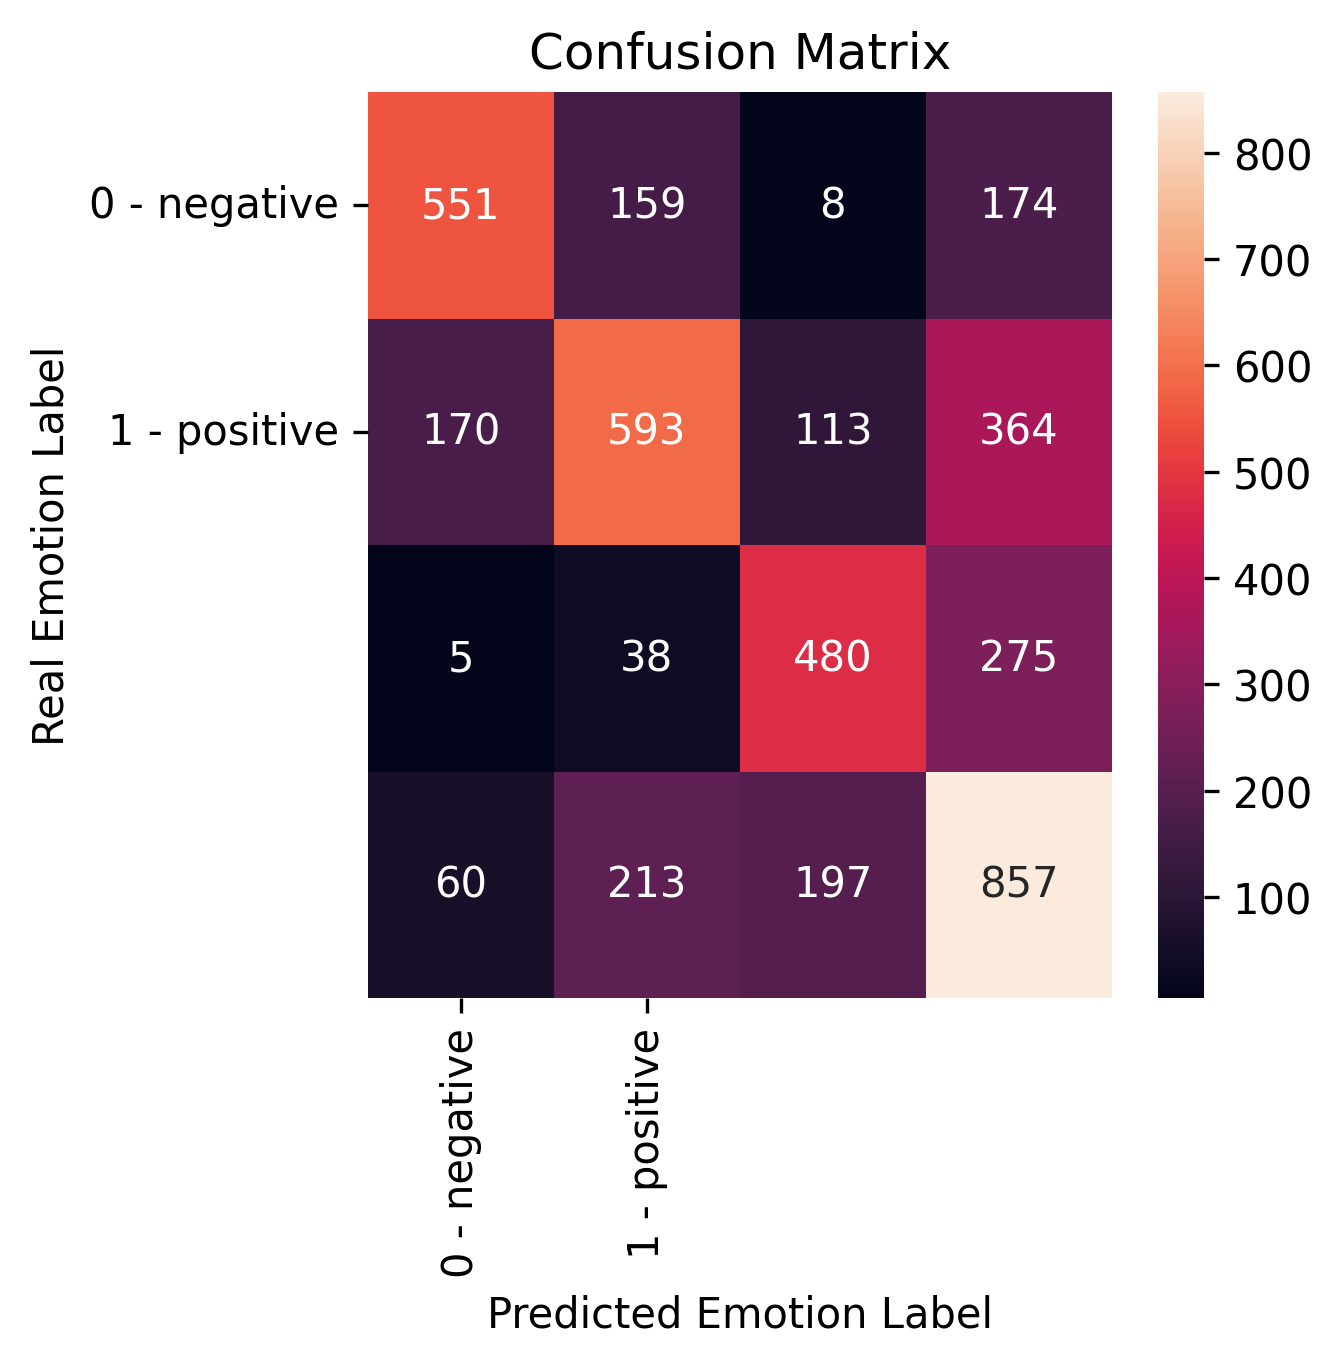

In [40]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df = df[(df["Duration"] < 8) & (df["Duration"] > 1.7)]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry+Sad, Neutral+Happy+Excited", results)